# Test finding conserved quantities in closed Toda 3 particles model

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os

from models import *
from hamiltonians import closed_toda_3
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

DTYPE=tf.float32
NP_DTYPE=np.float32

In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Settings

We work in Fourier basis, so num particles = 2 not 3 since we removed the center of mass

In [5]:
settings = {
    'hamiltonian': closed_toda_3,
    'd': 1,                    # space dimension
    'num_particles': 2,        # number of particles
    'minibatch_size': 2**10,    # Mini batch size
    'dataset_size': 2**10,      # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 3, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/closed_toda_3/",
    'ckpt_freq': 1000,
    'train_iters': 2,
    'visualize': True,
    'starter_learning_rate': 0.01,
    'decay_lr': False,
    'decay_steps': 5000,  # ignored if decay_lr False
    'decay_rate': 0.5,     # ignored if decay_lr False (decayed_learning_rate = learning_rate *
                           #                            decay_rate ^ (global_step / decay_steps))
    'min_learning_rate': 0.000001, # ignored if decay_lr False
    'loss': "dKdphi",
    'base_dist': "action_dirac_angle", 
    'value_actions': [.1, .2],
    'elastic_net_coeff': 0.
    }

Define the model T as sequence of symplectic transformations 

In [6]:
# To account for periodicity start with oscillator flow
stack = [OscillatorFlow()] 
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ZeroCenter(),
                  LinearSymplecticTwoByTwo(),
                  # tanh to bound the range due to exp
                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))]) 
#                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())]) 
T = Chain(stack)

Data, loss and train op:

In [7]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

z = make_data(settings, sess)

loss = make_loss(settings, T, z)

train_op = make_train_op(settings, loss, step)

In DiracDistribution constructor: actions =  [0.1 0.2]


Visualize before training: T is very close to identity, so circles are mapped to circles.

In [8]:
sess.run(tf.global_variables_initializer())

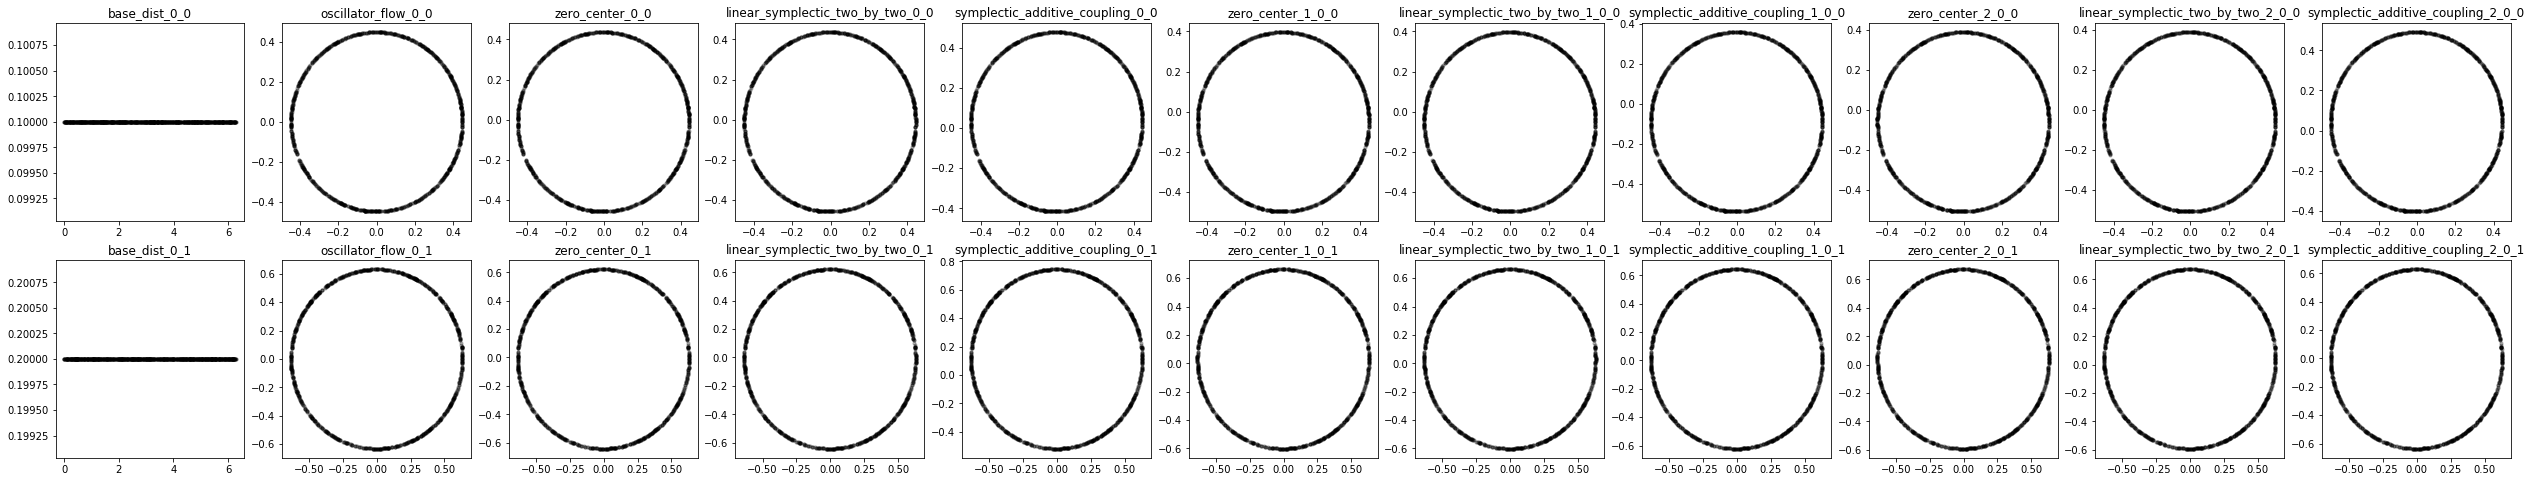

In [9]:
visualize_chain_bijector(T, z, sess=sess)

## Train

In [8]:
# Set the ZeroCenter bijectors to training mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = True

In [8]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/log/im_tests/closed_toda_3/model.ckpt.
INFO:tensorflow:global_step/sec: 58.4542
INFO:tensorflow:global_step/sec: 115.471
INFO:tensorflow:global_step/sec: 112.675
INFO:tensorflow:global_step/sec: 114.002
INFO:tensorflow:global_step/sec: 115.177
INFO:tensorflow:global_step/sec: 116.212
INFO:tensorflow:global_step/sec: 117.121
INFO:tensorflow:global_step/sec: 115.95
INFO:tensorflow:global_step/sec: 113.964
INFO:tensorflow:global_step/sec: 115.567
INFO:tensorflow:global_step/sec: 116.176
INFO:tensorflow:global_step/sec: 113.835
INFO:tensorflow:global_step/sec: 116.26
INFO:tensorflow:global_step/sec: 114.664
INFO:tensorflow:global_step/sec: 117.746
INFO:tensorflow:global_step/sec: 116.627
INFO:tensorflow:global_step/sec: 110.813
INFO:tensorflow:global_step/sec: 116.185
INFO:tenso

KeyboardInterrupt: 

## Test

In [9]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/closed_toda_3/model.ckpt-5013582


In [10]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = False

In [11]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  0.015003486


In [12]:
zz = tf.expand_dims(z[0,:,:,:],0)
x = zz
for i, bijector in enumerate(T.bijectors):        
    print(i, is_symplectic( bijector, x, sess=sess, rtol=1e-06, atol=1e-06))
    x = bijector(x)
print("Full flow:")
is_symplectic( T, zz, sess=sess, rtol=1e-05, atol=1e-05 )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
Full flow:


True

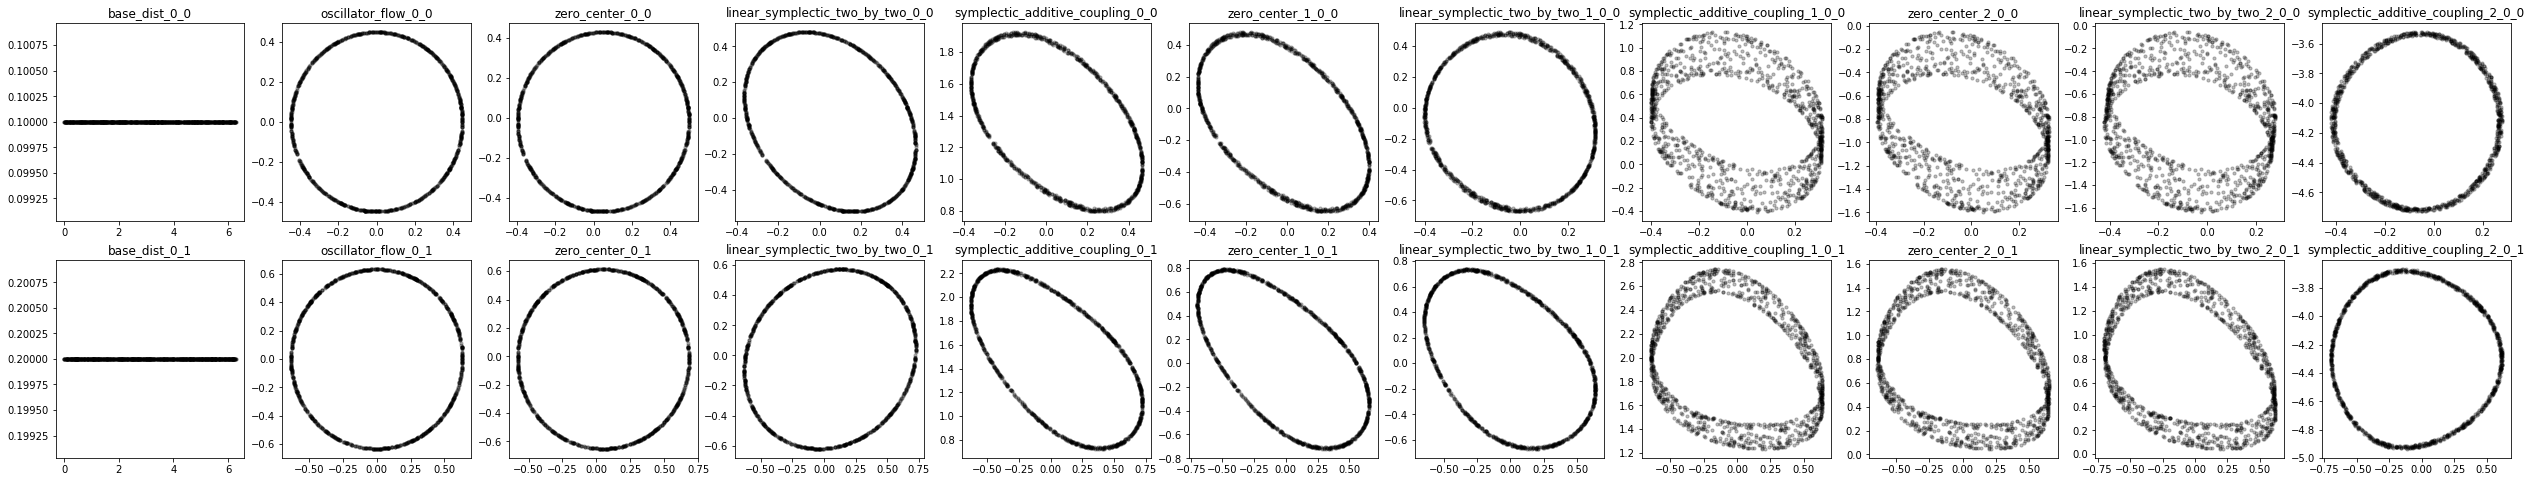

In [13]:
visualize_chain_bijector(T, z, sess=sess)

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
z0 = sess.run( tf.expand_dims(z[3,:,:,:],0) )
print(z0)
#x0 = tf.reshape([1.,0.2,1.,0.3,1.,0.4],[1,3,1,2])

[[[[2.6228683  0.1       ]
   [0.38630626 0.2       ]]]]


In [16]:
traj = sess.run( integrator(z0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
phi_traj, I_traj = extract_q_p( traj )

Visualize: the transformed trajectories

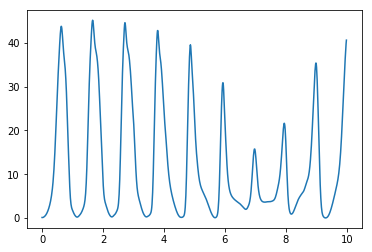

In [17]:
ts = np.arange(0.,10.,.01)

plt.plot(ts, I_traj[:,0,0,0])

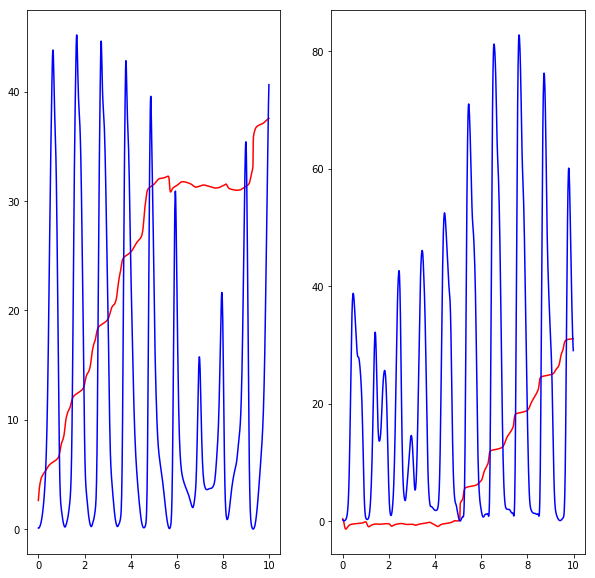

In [18]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, phi_traj[:,d,n,0],'r')
        plt.plot(ts, I_traj[:,d,n,0],'b')
        #plt.gca().set_aspect('equal', adjustable='box')

Not yet, but the angles almost linear...

Trajectories of original Hamiltonian

In [19]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# Map to original phase space the initial point
x0 = sess.run( T(z0) )
print(x0)
#x0 = tf.reshape([1.,0.2,1.,0.3,1.,0.4],[1,3,1,2])

[[[[ 0.06475502 -4.6743846 ]
   [ 0.41360444 -3.8968625 ]]]]


In [20]:
x0[:,:,:,1]

array([[[-4.6743846, -3.8968625]]], dtype=float32)

In [21]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

Visualize: the transformed trajectories

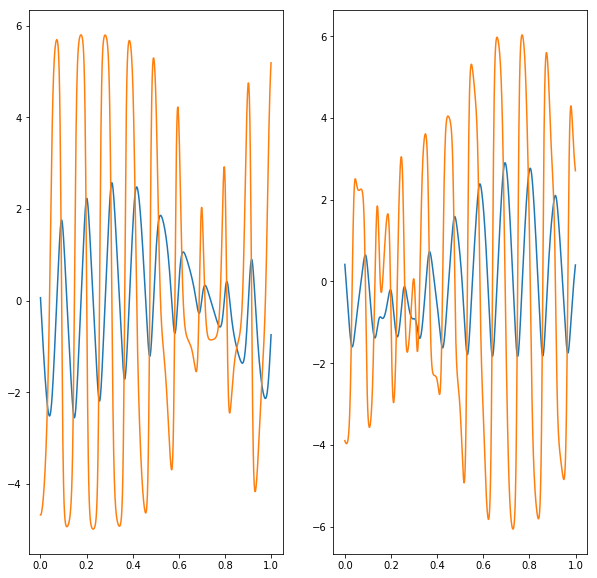

In [22]:
plt.figure(figsize=(10,10))

new_ts = np.arange(0.,1.,.001)

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(new_ts, qtraj[:,d,n,0])
        plt.plot(new_ts, ptraj[:,d,n,0])
        #plt.gca().set_aspect('equal', adjustable='box')

Map back to action/angle: we do not want all the way to I,phi; only till the cartesian coordinates in the action angle plane

In [23]:
# stop_at 1: do not run the inverse oscillator bijector which folds on upper half plane only.
trans_traj = sess.run(T.inverse(tf.constant(traj), stop_at=1)) 
phi_trans_traj,I_trans_traj = extract_q_p(trans_traj)

In [24]:
osc_traj = T.bijectors[0](tf.constant(trans_traj))
q_osc_traj,p_osc_traj = sess.run(extract_q_p(osc_traj))

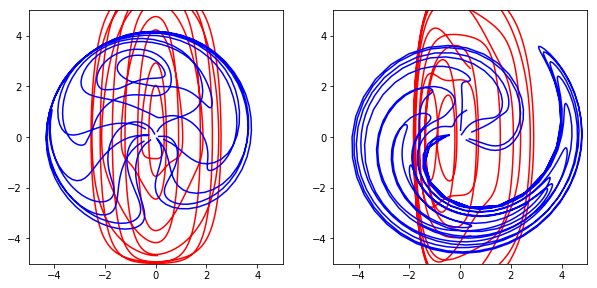

In [25]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0],'r')
        plt.plot(q_osc_traj[:,d,n,0], p_osc_traj[:,d,n,0],'b')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
        plt.gca().set_aspect('equal', adjustable='box')

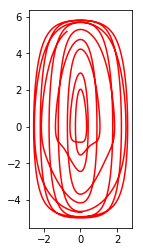

In [26]:
dd = 0; nn = 0
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')
plt.gca().set_aspect('equal', adjustable='box')

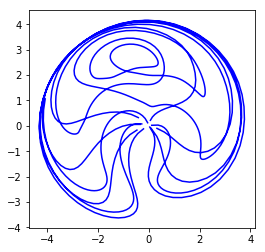

In [27]:
plt.plot(q_osc_traj[:,dd,nn,0], p_osc_traj[:,dd,nn,0],'b')
plt.gca().set_aspect('equal', adjustable='box')

## Conclusions

For the radii minimization loss, the model learns to set $K$ to zero within the region of sampling. This is in general not possible with a symplectic transformation - think about the case of oscillators and trying to set the Hamiltonian in the action-angle variables to zero. In fact it is possible with a time dependent canonical transformation like in Hamilton-Jacobi eq, where Hamilton principal function is its generating function (see Goldstein) but we will not consider it here.

Instead the transformation to $K=F_1$ makes sense and occurs when one solves time-independent Hamiltonian from the reduced Hamilton-Jacobi equation, and Hamilton characteristic function is its generating function (see Goldstein)